In [1]:
from music21 import *
import xml.etree.ElementTree as ET
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

In [2]:
us = environment.UserSettings()
us['musescoreDirectPNGPath']= '/usr/bin/musescore'

In [3]:
xml_dir = 'SymbTr/MusicXML/'

In [4]:
def hz2cents(pitch_hz, tonic=440):
    return 1200 * np.log2(pitch_hz/ float(tonic))

In [5]:
def plot_pitch_class_hist_from_csv(csv_pitch_file, tonic=note.Note('A4').pitch.frequency, target_dir=os.getcwd()):
    df = pd.read_csv(csv_pitch_file, header=None)
    voiced_pitches = np.array([p for p in df[1].values if p > 60])
    pitch_cents = hz2cents(voiced_pitches, tonic)
    pitch_cents = 100 * np.round(pitch_cents/100)
    pitch_cents = np.mod(pitch_cents, 1200)
   
    plt.figure()
    pitch_hist = plt.hist(pitch_cents, bins=np.arange(0,1201, 100))
    plt.savefig(os.path.join(target_dir, os.path.basename(csv_pitch_file)[:-4]+'_pitch_hist.png'))
    
    return pitch_hist

In [6]:
def plot_pitch_class_hist_from_pitches_list(pitches_list, tonic=note.Note('A4').pitch.frequency, \
                                      target_path='pitches_list_pitch_hist.png'):
    
    voiced_pitches = np.array([p for p in pitches_list if p > 60])
    pitch_cents = hz2cents(voiced_pitches, tonic)
    pitch_cents = 100 * np.round(pitch_cents/100)
    pitch_cents = np.mod(pitch_cents, 1200)
    plt.figure()
    pitch_hist = plt.hist(pitch_cents, bins=np.arange(0,1201, 100))
    plt.savefig(target_path)
    return pitch_hist

In [7]:
def remove_key_signatures(source_dir, xml_scorefile, target_dir):
    tree = ET.parse(os.path.join(source_dir, xml_scorefile))
    root = tree.getroot()
    
    # remove key signature
    for k in root.iter('key'):
        for ks in k.findall('key-step'):
            k.remove(ks)
        for ka in k.findall('key-accidental'):
            k.remove(ka)
        for ka in k.findall('key-alter'):
            k.remove(ka)
    # Save the new xml files to be later loaded with music21
    newMakamScore = os.path.join(target_dir, xml_scorefile[:-4] + '_withoutKeySignature.xml')
    tree.write(newMakamScore)
    return

In [8]:
def extract_pitches_from_score(source_dir, xml_score_without_key_sign):
    pitch_list=[]
    s = converter.parse(os.path.join(source_dir, xml_score_without_key_sign))
    for n in s.flat.notes:
        if n.duration.isGrace :
            continue
        dur = int(n.duration.quarterLengthNoTuplets*16)
        if(n.pitch.accidental != None):
            accidental = n.pitch.accidental.name
            for k, v in makamAccidentals_dict.items():
                if k == accidental:
                    n.pitch.accidental = None
                    n.pitch.microtone = v*200/9
                                       
        pitch_list.extend([n.pitch.frequency]*dur)
        
    return pitch_list

In [9]:
makamAccidentals_dict = {'double-slash-flat':-8,
                    'flat':-5,
                    'slash-flat': -4 ,
                    'quarter-flat': -1,
                    'half-flat':-1,    
                    'quarter-sharp': 1,
                    'half-sharp': 1,
                    'sharp':4,
                    'slash-quarter-sharp':5,
                    'slash-sharp':8}

### With all necessary functions and constants defined, experiment starts here

We list all the huseyni makam scores in the dataset

In [11]:
huseyni_scores =  [score for score in os.listdir(xml_dir) if 'huseyni--' in score]
huseyni_scores_dir = 'huseyni_scores'
os.makedirs(huseyni_scores_dir, exist_ok=True)
#os.path.join(xml_dir,huseyni_scores[0])

Remove the key signatures from scores to make the scores readable by music21m

In [12]:
for score in huseyni_scores:
    remove_key_signatures(xml_dir,score, huseyni_scores_dir)

In [13]:
!ls huseyni_scores | wc -l   # No of scores obtained

99


In [14]:
huseyni_scores_without_key_sign =  [score for score in os.listdir(huseyni_scores_dir)]

In [15]:
pitch_list_makam_scores = []
for score in huseyni_scores_without_key_sign:
    pitch_list_makam_scores.extend(extract_pitches_from_score(huseyni_scores_dir, score))
    #print(len(pitch_list_makam_scores))


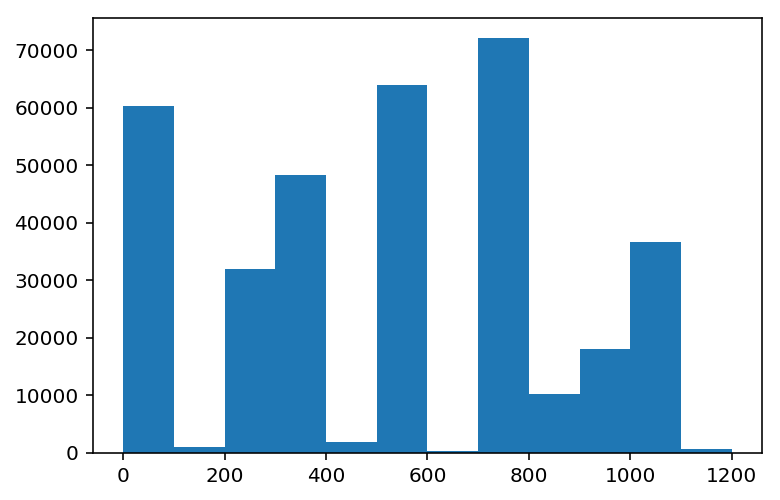

In [16]:
pitch_hist_makam = plot_pitch_class_hist_from_pitches_list(pitch_list_makam_scores, 
                                  tonic=note.Note('A4').pitch.frequency,
                                  target_path='makam_scores_pitch_hist.png')

In [51]:
print(np.flip(np.argsort(pitch_hist_makam[0]))[:7])
#print((np.flip(np.argsort(pitch_hist_makam[0])) - np.flip(np.argsort(pitch_hist_makam[0]))[0])%12)


[ 7  5  0  3 10  2  9]


[ 0  2  3 11  5  4 10]


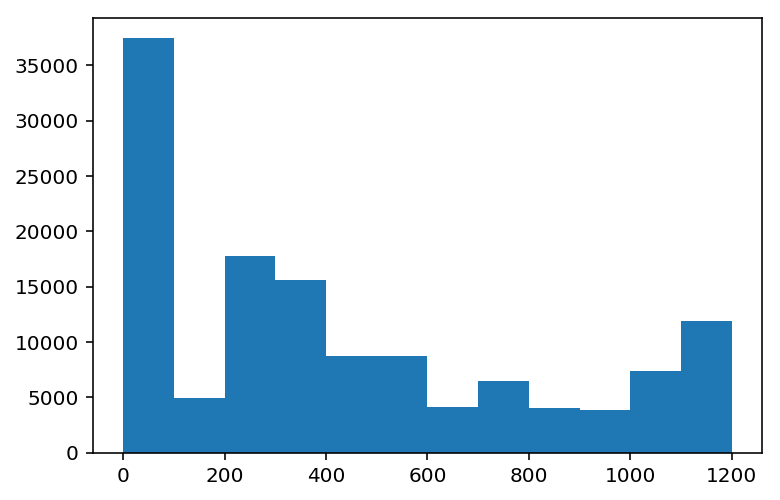

In [52]:
pitch_hist_hindustani = plot_pitch_class_hist_from_csv('raga_husaini_pitch_data.csv', 
                                                       tonic=note.Note('E4').pitch.frequency)

print(np.flip(np.argsort(pitch_hist_hindustani[0]))[:7])


[0 7 2 9 5 3 8]
[ 0  7  2  9  5  3  8 10 11  6  1  4]


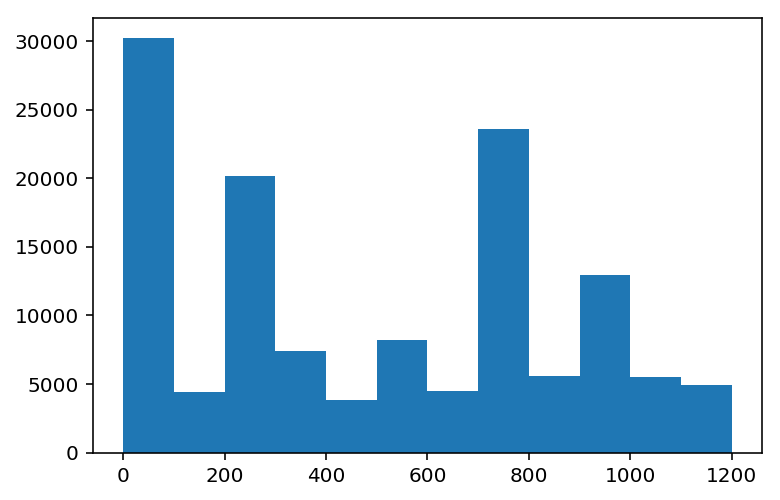

In [29]:
pitch_hist_carnatic_audio = plot_pitch_class_hist_from_csv('45ab8e5a-e7af-4244-a0f5-be6b68a74191raga_huseni_pitch_data.csv', tonic=note.Note('D4').pitch.frequency)
print(np.flip(np.argsort(pitch_hist_carnatic_audio[0]))[:7])
sorted_pitch_classes = np.flip(np.argsort(pitch_hist_carnatic_audio[0]))
print((sorted_pitch_classes - sorted_pitch_classes[0])%12)


In [20]:
! mkdir -p makam_audio_histograms

[ 0  7  5  3  8  2 10  1  4  9 11  6]
[ 0 11 10  9  8  7  6  5  4  3  2  1]
[ 0  7  5  8 10  9  3  4  2  1 11  6]
[ 0  5 10  8  6  1  3  2  7  9  4 11]
[ 0 10  5  1  3  2  8  7  6 11  9  4]
[ 0  7  5  3  2  9 10  1  8  4 11  6]
[ 0  5  3 10  8  1  2  6  7  4  9 11]
[ 0  5  8 10  6  3  1  7  2  9 11  4]
[ 0  7 10  2  5  4  9  3  8 11  6  1]
[ 0  7  5  3 10  9  8  1  2  6  4 11]
[ 0  7  2  1  6  8 11  4  3  5 10  9]
[ 0  5  7  3 10  2  9  1  8  6  4 11]


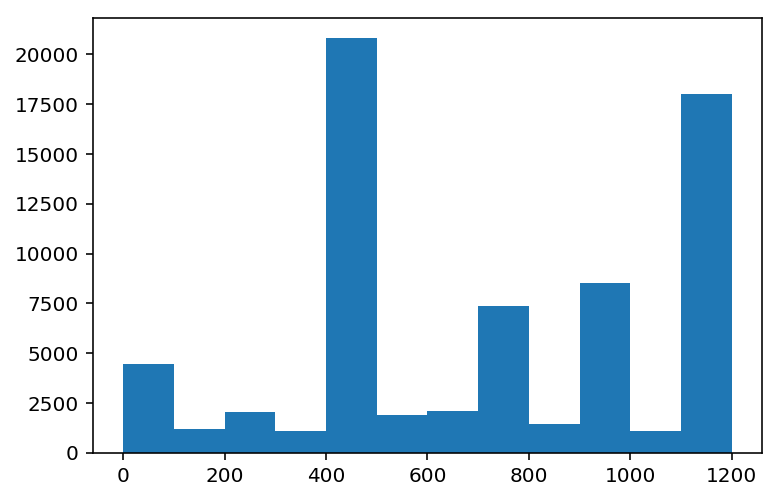

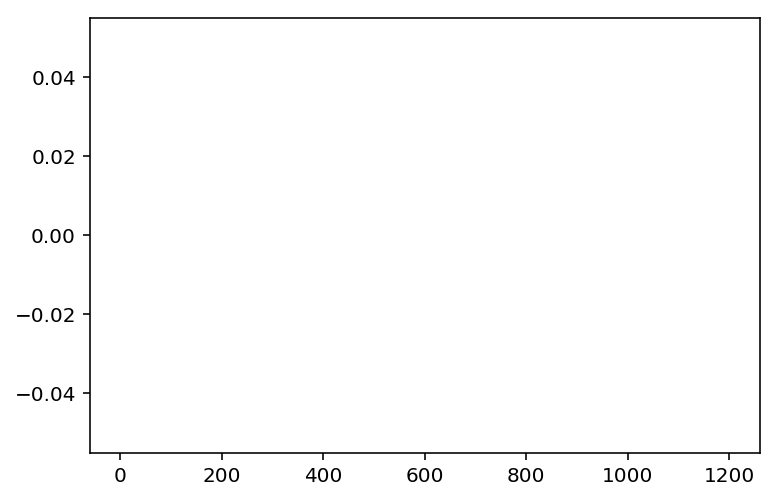

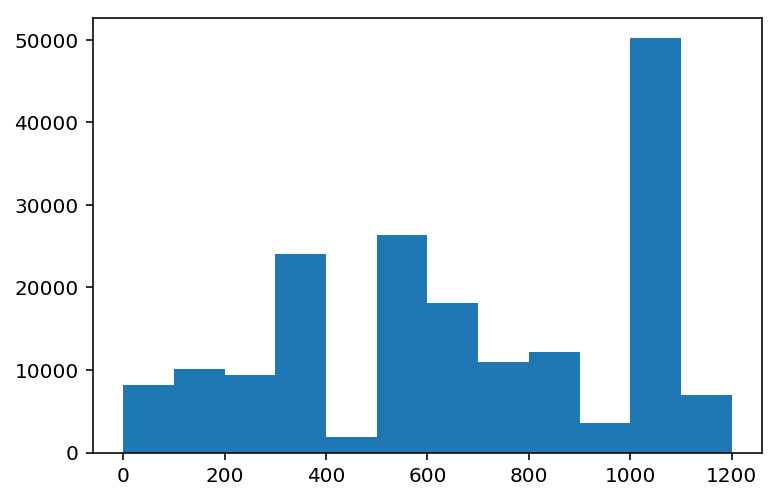

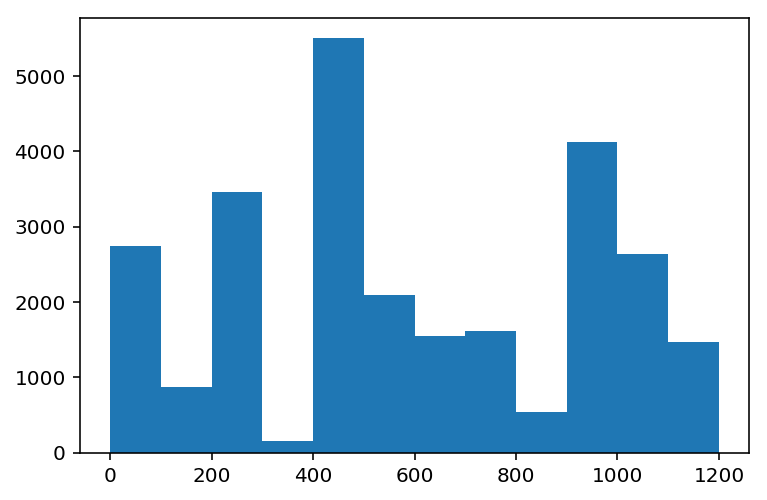

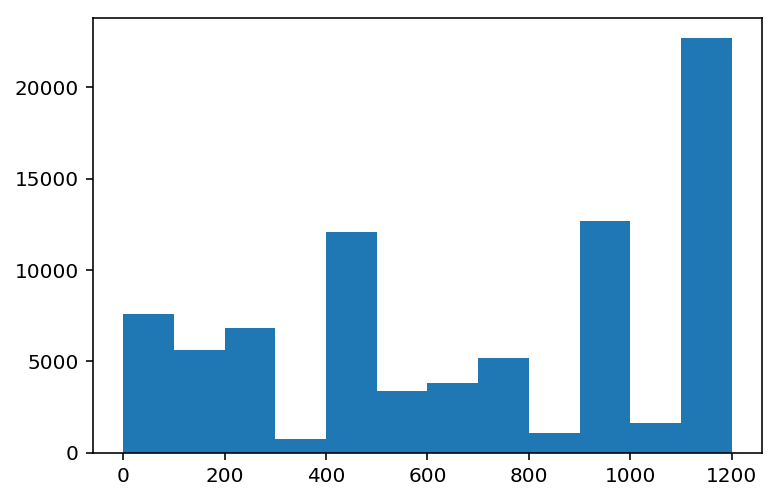

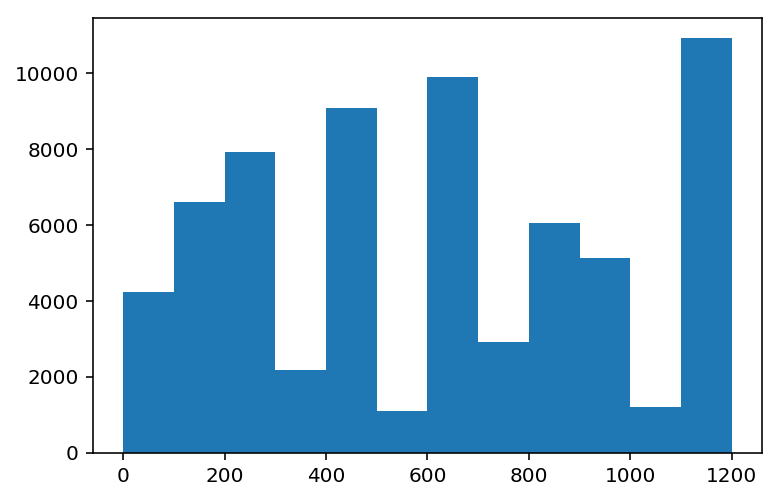

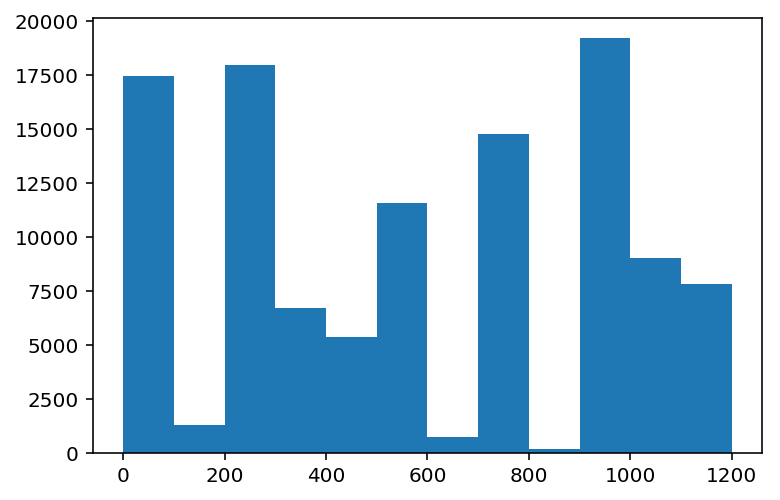

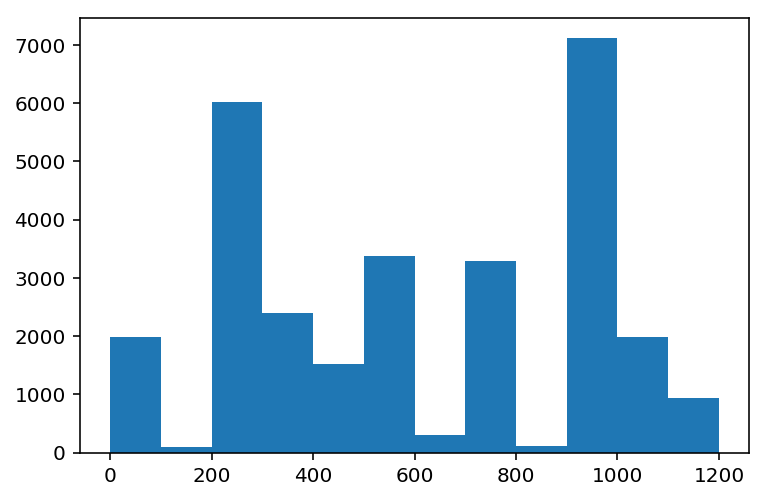

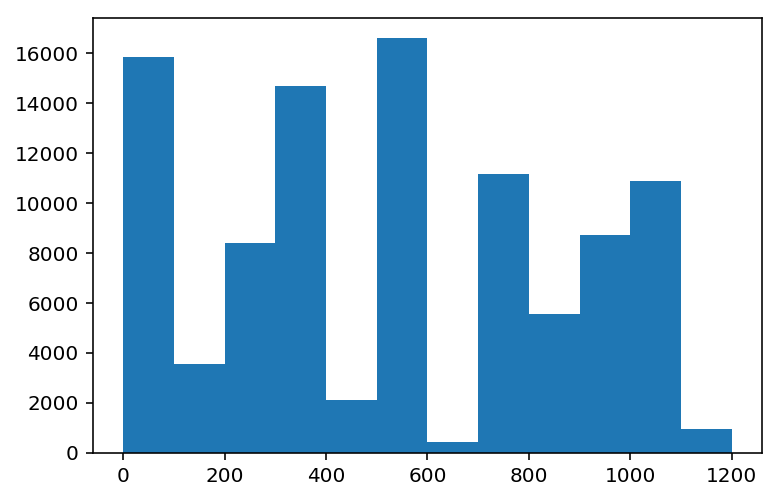

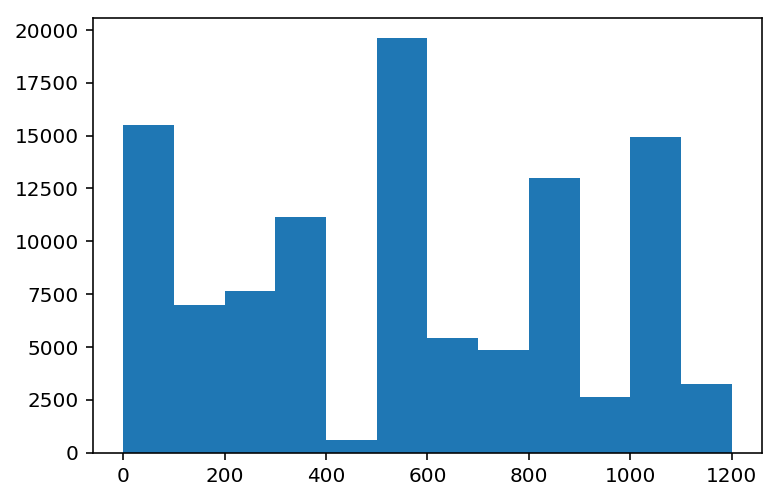

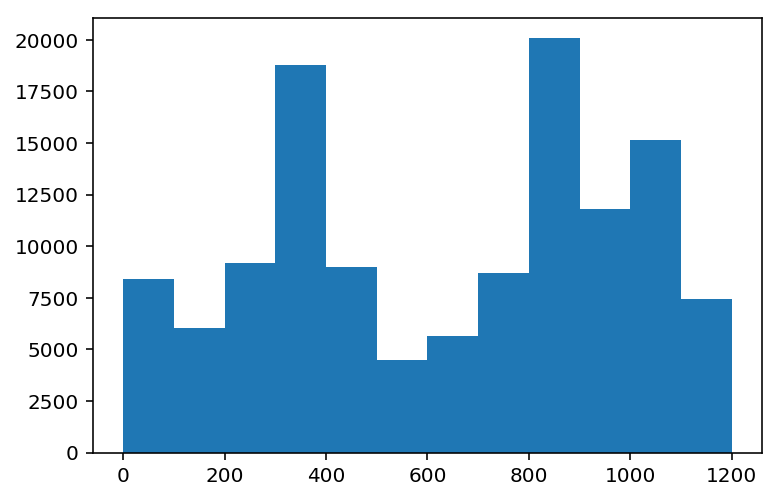

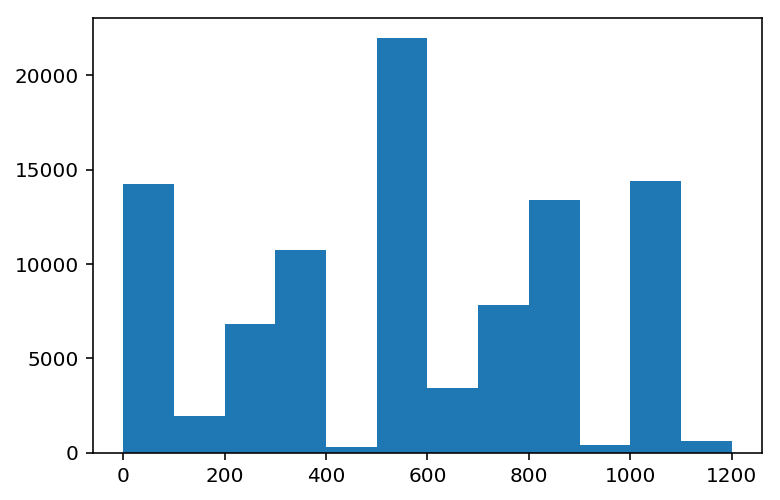

In [21]:
for f in os.listdir('makam_audio_pitch_data'):
    #print(f)
    pitch_hist_makam_audio = plot_pitch_class_hist_from_csv(csv_pitch_file=os.path.join('makam_audio_pitch_data',f),
                                                            tonic=note.Note('A4').pitch.frequency, 
                                                            target_dir='makam_audio_histograms')
    
    sorted_pitch_classes = np.flip(np.argsort(pitch_hist_makam_audio[0]))
    print((sorted_pitch_classes - sorted_pitch_classes[0])%12)

[ 7  5  9 10  4  2  3  8  0 11  6  1]


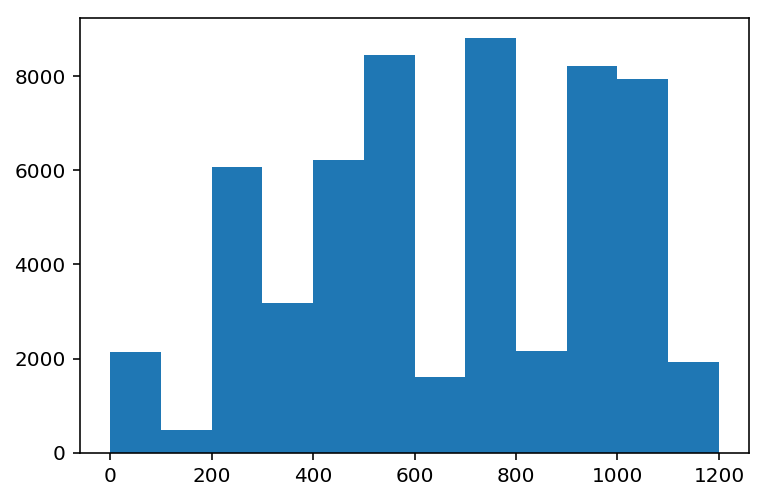

In [57]:
pitch_hist_makam_audio = plot_pitch_class_hist_from_csv('56b567da-b428-45cd-b76a-b944a91bf876_pitch_data.csv', tonic=note.Note('A4').pitch.frequency)
print(np.flip(np.argsort(pitch_hist_makam_audio[0])))
#print(((np.flip(np.argsort(pitch_hist_makam_audio[0])) - )%12))